In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp

import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.externals import joblib

sns.set_style('dark')

SEED = 1231
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

** Load Training File **

In [2]:
dtypes = {
    'siteid': 'float32',
    'offerid': 'uint32',
    'category': 'uint32',
    'merchant': 'uint32'
}

train = pd.read_csv('../data/raw/205e1808-6-dataset/train.csv', 
                    dtype=dtypes,
                    parse_dates=['datetime']
                   )

test = pd.read_csv('../data/raw/205e1808-6-dataset/test.csv', 
                    dtype=dtypes,
                    parse_dates=['datetime']
                   )

## Dyakonov's Advice ##

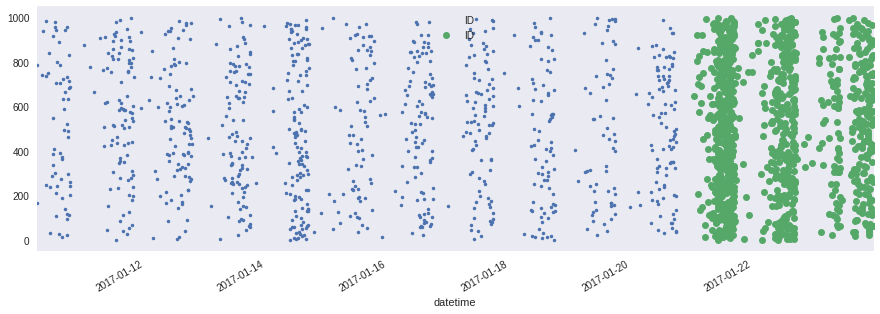

In [23]:
# plot the first 100 rows in training and test set to see if we are being tested on
# same time period

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ss = train[['datetime', 'ID']]
ss = ss.assign(ID=np.arange(0, len(train)))

zz = test[['datetime', 'ID']]
zz = zz.assign(ID=np.arange(0, len(test)))

ss.plot(x='datetime', y='ID', style='.', ax=ax)
zz.plot(x='datetime', y='ID', style='o', ax=ax);

In [76]:
train.columns

Index(['ID', 'datetime', 'siteid', 'offerid', 'category', 'merchant',
       'countrycode', 'browserid', 'devid', 'click'],
      dtype='object')

** Distribution of the target variable. **

In [97]:
train.click.value_counts()

0    11700596
1      437214
Name: click, dtype: int64

In [98]:
train.click.value_counts(normalize=True)

0    0.963979
1    0.036021
Name: click, dtype: float64

** SiteId: Website Id on which the ad was displayed **

Let's visualize the frequency plot of site ids on which the ads were displayed

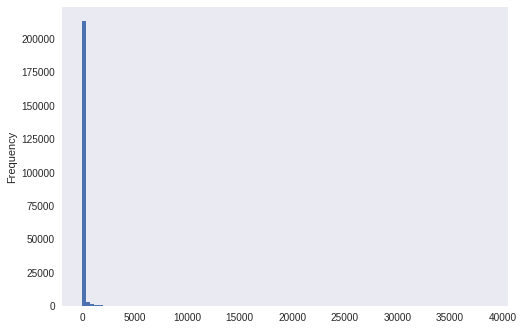

In [87]:
freq_count = train.siteid.value_counts()
freq_count.plot(kind='hist', bins=100);

In [107]:
train.loc[train.siteid.isin(freq_count[freq_count > 100].index), 'click'].value_counts(normalize=True)

0    0.988565
1    0.011435
Name: click, dtype: float64

In [108]:
train.loc[train.siteid.isin(freq_count[freq_count < 100].index), 'click'].value_counts(normalize=True)

0    0.864988
1    0.135012
Name: click, dtype: float64

In [109]:
train.loc[train.siteid.isin(freq_count[freq_count > 10].index), 'click'].value_counts(normalize=True)

0    0.983113
1    0.016887
Name: click, dtype: float64

In [110]:
train.loc[train.siteid.isin(freq_count[freq_count < 10].index), 'click'].value_counts(normalize=True)

1    0.719167
0    0.280833
Name: click, dtype: float64

In [116]:
st = time.clock()
siteid_count = train.groupby('siteid')['siteid'].transform(lambda x: len(x))
train        = train.assign(siteid_count=siteid_count)
et = time.clock()

del siteid_count
gc.collect()

print('Took: {} seconds to generate count variable'.format((et - st)))

Took: 14.651640999999998 seconds to generate count variable


In [119]:
st = time.clock()
print(pd.crosstab(train.siteid_count, train.click))
et = time.clock()

print('Took: {} seconds to generate cross tabulation '.format((et - st)))

click             0      1
siteid_count              
1.0             631  98305
2.0            2218  31924
3.0            5055  20535
4.0            5816  16480
5.0            6599  12876
6.0            8286  10044
7.0            9456   7491
8.0           16452   6140
9.0           27312   5745
10.0          28915   5165
11.0           9368   2952
12.0           7601   1987
13.0           7368   1706
14.0          10323   1577
15.0          18327   1833
16.0          31517   2115
17.0          46242   2361
18.0          55987   2747
19.0          51983   2870
20.0          36306   2334
21.0          15229   1361
22.0          14112   1244
23.0          14764   1129
24.0          18356   1036
25.0          28102   1348
26.0          44899   1641
27.0          57993   2163
28.0          61925   2307
29.0          49757   2095
30.0          31180   1400
...             ...    ...
9091.0         9081     10
9262.0         9209     53
9410.0         9381     29
9417.0         9402     15
9

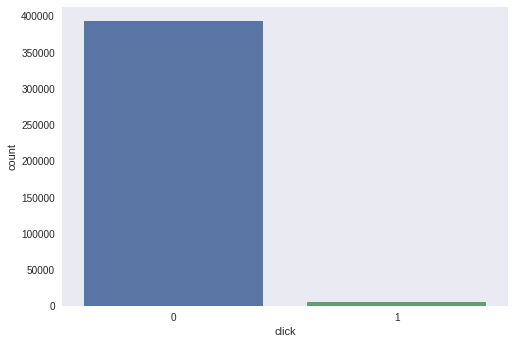

In [130]:
sns.countplot(train.loc[train.siteid_count > 10000, 'click']);

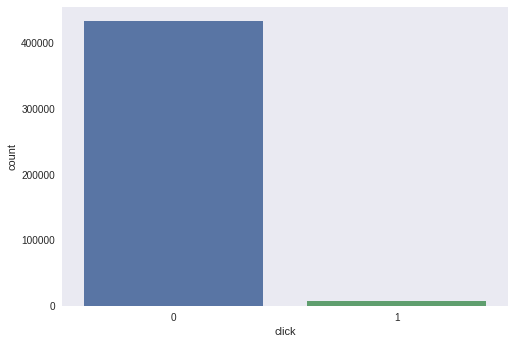

In [131]:
sns.countplot(train.loc[(train.siteid_count > 5000) & (train.siteid_count < 10000), 'click']);

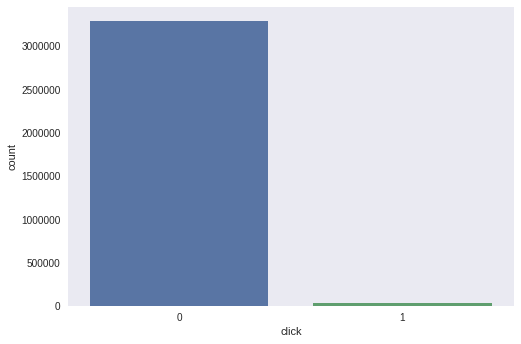

In [132]:
sns.countplot(train.loc[(train.siteid_count > 1000) & (train.siteid_count < 5000), 'click']);

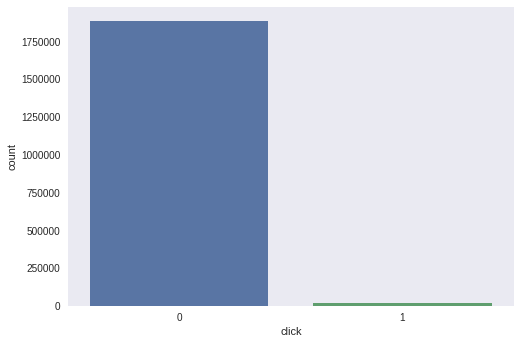

In [133]:
sns.countplot(train.loc[(train.siteid_count > 500) & (train.siteid_count < 1000), 'click']);

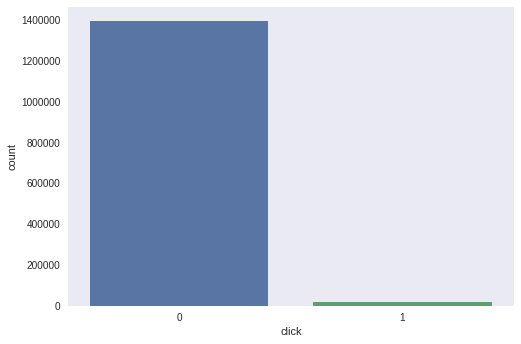

In [134]:
sns.countplot(train.loc[(train.siteid_count > 250) & (train.siteid_count < 500), 'click']);

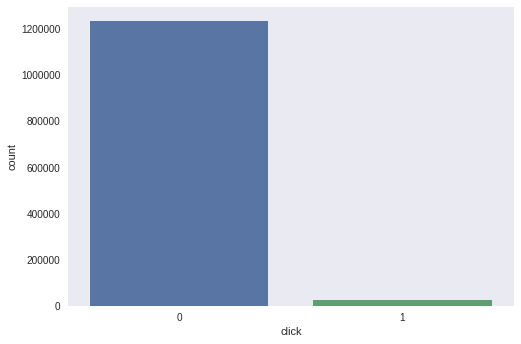

In [135]:
sns.countplot(train.loc[(train.siteid_count > 100) & (train.siteid_count < 250), 'click']);

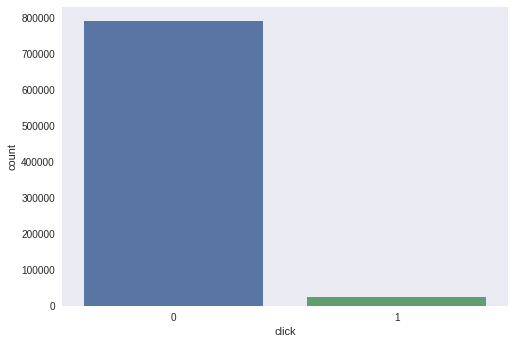

In [136]:
sns.countplot(train.loc[(train.siteid_count > 50) & (train.siteid_count < 100), 'click']);

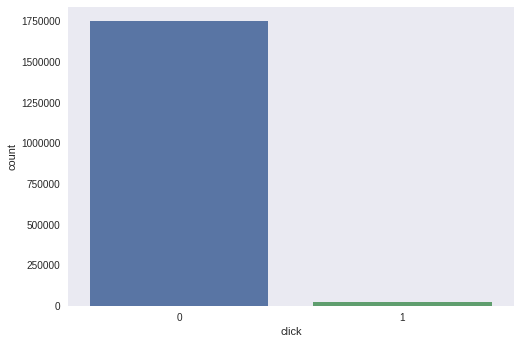

In [143]:
sns.countplot(train.loc[(train.siteid_count > 200) & (train.siteid_count < 500), 'click']);

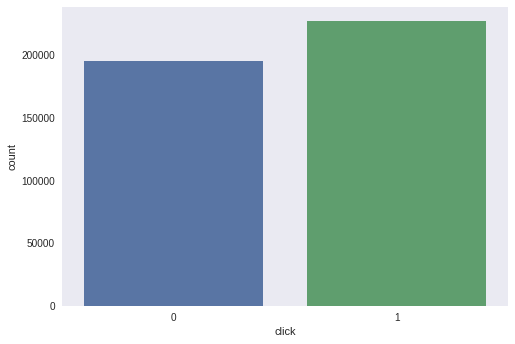

In [150]:
sns.countplot(train.loc[(train.siteid_count > 0) & (train.siteid_count < 17), 'click']);

### How to construct cross-validation scheme ? 

In [3]:
len(set(test.category) - set(train.category))

0

In [4]:
len(set(train.category) - set(test.category))

4

In [5]:
len(set(test.merchant) - set(train.merchant))

6

In [6]:
len(set(test.countrycode) - set(train.countrycode))

0

In [7]:
len(set(test.browserid) - set(train.browserid))

0

In [8]:
len(set(test.devid) - set(train.devid))

0

In [9]:
len(set(test.offerid) - set(train.offerid))

36843

In [25]:
train.groupby(train.datetime.dt.hour)['click'].apply(lambda x: len(x[x == 1]) / len(x))

datetime
0     0.376891
1     0.336403
2     0.022869
3     0.027938
4     0.029557
5     0.028768
6     0.026498
7     0.038357
8     0.032615
9     0.030617
10    0.032884
11    0.027717
12    0.025526
13    0.025911
14    0.025045
15    0.023506
16    0.024169
17    0.024808
18    0.046388
19    0.114185
20    0.467624
21    0.477524
22    0.473212
23    0.432123
Name: click, dtype: float64

In [37]:
ss = train.groupby([train.datetime.dt.day, train.datetime.dt.hour])\
      ['click'].apply(lambda x: len(x[x == 1 ]) / len(x))

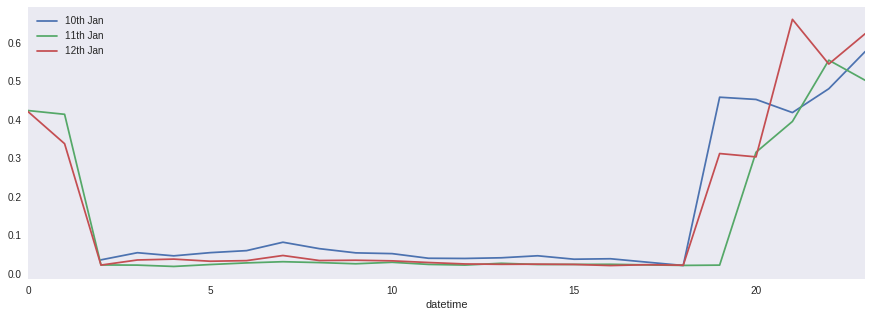

In [42]:
plt.figure(figsize=(15, 5))
ss.ix[10].plot(label='10th Jan')
ss.ix[11].plot(label='11th Jan')
ss.ix[12].plot(label='12th Jan')
plt.legend(loc='best');

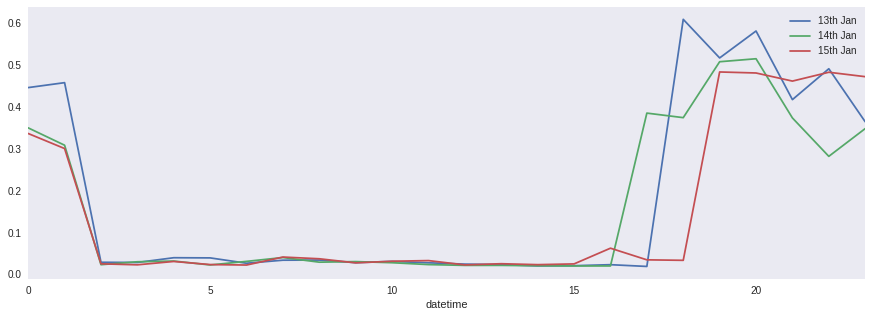

In [43]:
plt.figure(figsize=(15, 5))
ss.ix[13].plot(label='13th Jan')
ss.ix[14].plot(label='14th Jan')
ss.ix[15].plot(label='15th Jan')
plt.legend(loc='best');

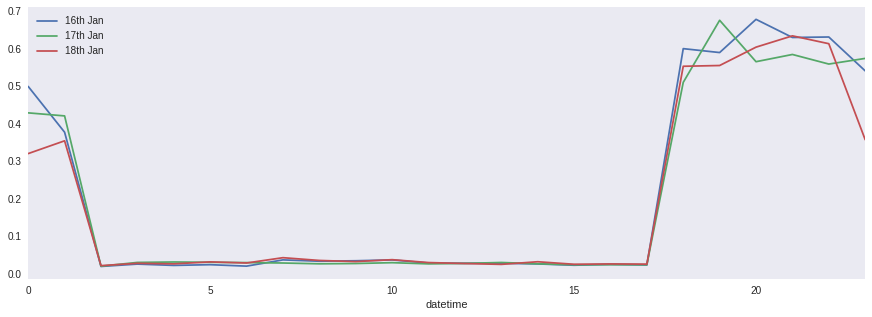

In [44]:
plt.figure(figsize=(15, 5))
ss.ix[16].plot(label='16th Jan')
ss.ix[17].plot(label='17th Jan')
ss.ix[18].plot(label='18th Jan')
plt.legend(loc='best');

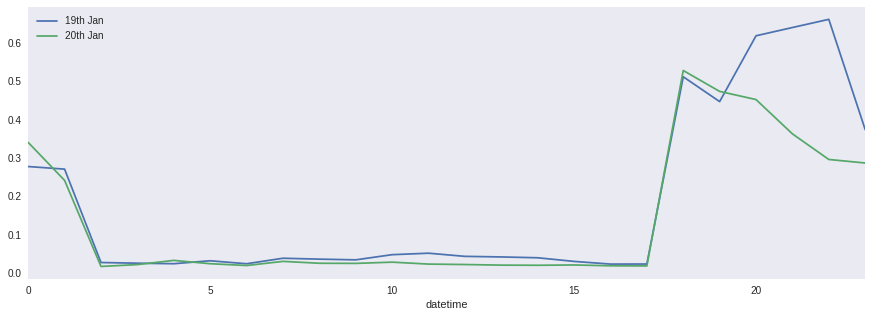

In [45]:
plt.figure(figsize=(15, 5))
ss.ix[19].plot(label='19th Jan')
ss.ix[20].plot(label='20th Jan')
plt.legend(loc='best');

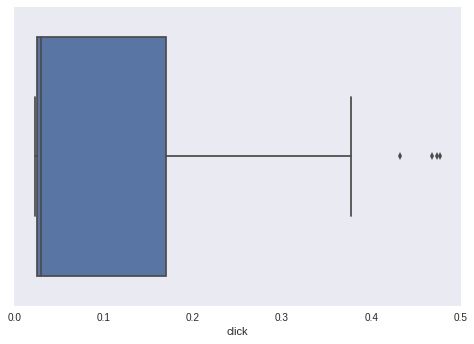

In [26]:
sns.boxplot(_);

### Cross Validation

Thinking of creating a time based split

In [3]:
train = train.assign(hour_of_day=train.datetime.dt.hour)
train = train.assign(prime_time=train.hour_of_day.isin([0, 1, 19, 20, 21, 22, 23]).astype(np.int))

test  = test.assign(hour_of_day=test.datetime.dt.hour)
test  = test.assign(prime_time=test.hour_of_day.isin([0, 1, 19, 20, 21, 22, 23]).astype(np.int))

In [2]:
mask = (train.datetime < '2017-01-14') | (train.datetime > '2017-01-16')

X_train = train.loc[mask, ['hour_of_day', 'prime_time']]
y_train = train.loc[mask, 'click']

X_valid = train.loc[~mask, ['hour_of_day', 'prime_time']]
y_valid = train.loc[~mask, 'click']

NameError: name 'train' is not defined

In [56]:
print(len(X_train), len(X_valid))

9812079 2325731


** Basic Model **

In [57]:
del train, test
gc.collect()

116

In [158]:
# preprocessing
# since there are missing values in siteid_count variable, replace it with 0
X_train.loc[:, 'siteid_count'] = X_train.siteid_count.fillna(0)
X_valid.loc[:, 'siteid_count'] = X_valid.siteid_count.fillna(0)

In [59]:
model = RandomForestClassifier(max_depth=3, random_state=SEED, n_jobs=2)
model.fit(X_train, y_train)

preds = model.predict_proba(X_valid)[:, 1]
print('AUC score on validaiton set: {}'.format(roc_auc_score(y_valid, preds)))

AUC score on validaiton set: 0.6483337645381928


In [60]:
del X_train, X_valid, y_train, y_valid
gc.collect()

26

** Final Training **

In [4]:
st = time.clock()
model = RandomForestClassifier(max_depth=3, n_jobs=2, random_state=SEED)
model.fit(train[['hour_of_day', 'prime_time']], train['click'])
et = time.clock()

joblib.dump(model, '../data/processed/hour_of_day_model.pkl')
print('Took: {} seconds to train the model'.format((et - st)))

Took: 52.982914 seconds to train the model


In [5]:
final_preds = model.predict_proba(test[['hour_of_day', 'prime_time']])[:, 1]

In [13]:
sub = pd.read_csv('../data/raw/205e1808-6-dataset/sample_submission.csv')

In [14]:
sub.head(5)

,ID,click
0,IDE4beP,0.5
1,IDfo26Y,0.5
2,IDYZM6I,0.5
3,ID8CVw1,0.5
4,IDPltMK,0.5


In [15]:
sub.loc[:, 'ID']    = test.ID
sub.loc[:, 'click'] = final_preds

In [16]:
sub.to_csv('../submissions/hour_of_day.csv', index=False)
!zip '../submissions/hour_of_day.csv.zip' '../submissions/hour_of_day.csv'
!rm '../submissions/hour_of_day.csv'

  adding: ../submissions/hour_of_day.csv (deflated 81%)
